In [1]:
!pip install --upgrade scikit-learn imbalanced-learn xgboost --quiet

In [2]:
# Cell 1: Initial setup and data cleaning

import pandas as pd

# Load dataset
df = pd.read_csv("/kaggle/input/heart-attack-prediction-dataset/heart_attack_prediction_dataset.csv")

# Drop irrelevant or problematic columns including 'Sex'
columns_to_drop = [
    'Patient ID', 'Country', 'Continent', 'Hemisphere',
    'Income', 'Diet', 'Sleep Hours Per Day', 'Sedentary Hours Per Day',
    'Stress Level', 'Alcohol Consumption', 'Sex'
]
df.drop(columns=columns_to_drop, inplace=True)

# Split 'Blood Pressure' into systolic and diastolic numeric columns
bp_split = df['Blood Pressure'].str.split('/', expand=True)
df['BP_Systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
df['BP_Diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
df.drop(columns='Blood Pressure', inplace=True)

# Optional reorder columns (not necessary)
cols = df.columns.tolist()
cols.insert(cols.index('Heart Attack Risk'), cols.pop(cols.index('BP_Systolic')))
cols.insert(cols.index('Heart Attack Risk'), cols.pop(cols.index('BP_Diastolic')))
df = df[cols]

# Show cleaned data
df.head()


,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Exercise Hours Per Week,Previous Heart Problems,Medication Use,BMI,Triglycerides,Physical Activity Days Per Week,BP_Systolic,BP_Diastolic,Heart Attack Risk
0,67,208,72,0,0,1,0,4.168189,0,0,31.251233,286,0,158,88,0
1,21,389,98,1,1,1,1,1.813242,1,0,27.194973,235,1,165,93,0
2,21,324,72,1,0,0,0,2.078353,1,1,28.176571,587,4,174,99,0
3,84,383,73,1,1,1,0,9.828130,1,0,36.464704,378,3,163,100,0
4,66,318,93,1,1,1,1,5.804299,1,0,21.809144,231,1,91,88,0


In [3]:
# Cell 2: Feature categorization and missing values handling

import numpy as np

target = 'Heart Attack Risk'

# Now all features are either numerical or binary (int/float), no categorical
binary = [
    'Diabetes', 'Family History', 'Smoking', 'Obesity',
    'Previous Heart Problems', 'Medication Use'
]
numerical = [col for col in df.columns if col not in binary + [target]]

print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing values (or impute if preferred)
df.dropna(inplace=True)

print(f"\nFinal dataset shape after cleaning: {df.shape}")
print("\nData types summary:")
print(df.dtypes)

Missing values per column:
Age                                0
Cholesterol                        0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Exercise Hours Per Week            0
Previous Heart Problems            0
Medication Use                     0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
BP_Systolic                        0
BP_Diastolic                       0
Heart Attack Risk                  0
dtype: int64

Final dataset shape after cleaning: (8763, 16)

Data types summary:
Age                                  int64
Cholesterol                          int64
Heart Rate                           int64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int6

In [4]:

# Cell 3: Train-test split with stratification

from sklearn.model_selection import train_test_split

X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Class distribution in full dataset:")
print(y.value_counts(normalize=True))
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))


Class distribution in full dataset:
Heart Attack Risk
0    0.641789
1    0.358211
Name: proportion, dtype: float64

Class distribution in training set:
Heart Attack Risk
0    0.641797
1    0.358203
Name: proportion, dtype: float64

Class distribution in test set:
Heart Attack Risk
0    0.641757
1    0.358243
Name: proportion, dtype: float64


In [5]:
# Cell 4: Preprocessing pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# All features numeric or binary, so only scale numerical, leave binary as-is
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical)
    ],
    remainder='passthrough'  # binary columns remain unchanged
)

In [6]:
# Cell 5: Create pipeline with SMOTE inside

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('xgb_classifier', xgb_classifier)
])


In [7]:
# Cell 6: Hyperparameter tuning with RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'xgb_classifier__n_estimators': [100, 200, 300],
    'xgb_classifier__max_depth': [3, 5, 7],
    'xgb_classifier__learning_rate': [0.01, 0.05, 0.1],
    'xgb_classifier__subsample': [0.6, 0.8, 1.0],
    'xgb_classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb_classifier__min_child_weight': [1, 3, 5],
    'xgb_classifier__gamma': [0, 0.1, 0.3]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    verbose=2,
    random_state=42
)

search.fit(X_train, y_train)

print("Best parameters found:", search.best_params_)
print("Best F1 score from CV:", search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   0.9s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsam

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.0s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.1s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.5s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.3s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.5s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   1.4s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   1.3s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.5s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.5s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.5s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   1.4s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=100, xgb_classifier__subsamp

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   1.3s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   1.2s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   1.2s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   1.6s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.8s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   0.6s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.4s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   0.7s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   0.7s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.8; total time=   2.3s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.8s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.8s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.8s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.9s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.9s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   0.8s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=300, xgb_classifier__subsample=0.6; total time=   0.9s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   0.7s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   0.7s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   0.7s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   0.9s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   0.8s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.05, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   1.1s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   1.1s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=1.0; total time=   1.1s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.8; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.6; total time=   2.1s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.6; total time=   2.1s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.6; total time=   2.1s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.5s
[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.6; total time=   2.0s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.5s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.3, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=1.0, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.6; total time=   2.1s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.8; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.8; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.8; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.8; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=3, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.8; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.8, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=5, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=1.0; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0.1, xgb_classifier__learning_rate=0.1, xgb_classifier__max_depth=7, xgb_classifier__min_child_weight=1, xgb_classifier__n_estimators=100, xgb_classifier__subsample=0.6; total time=   1.0s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.6; total time=   0.6s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subs

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.6; total time=   0.6s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.6; total time=   0.4s
[CV] END xgb_classifier__colsample_bytree=0.6, xgb_classifier__gamma=0, xgb_classifier__learning_rate=0.01, xgb_classifier__max_depth=3, xgb_classifier__min_child_weight=5, xgb_classifier__n_estimators=200, xgb_classifier__subsample=0.6; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:05:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'xgb_classifier__subsample': 0.8, 'xgb_classifier__n_estimators': 300, 'xgb_classifier__min_child_weight': 1, 'xgb_classifier__max_depth': 7, 'xgb_classifier__learning_rate': 0.1, 'xgb_classifier__gamma': 0.1, 'xgb_classifier__colsample_bytree': 0.6}
Best F1 score from CV: 0.2582843782126771


In [8]:
# Cell 7: Evaluate best model on test data

from sklearn.metrics import classification_report, accuracy_score, f1_score

best_pipeline = search.best_estimator_

y_pred = best_pipeline.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.5824
Test F1 Score: 0.2591
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.79      0.71      1125
           1       0.36      0.20      0.26       628

    accuracy                           0.58      1753
   macro avg       0.50      0.50      0.48      1753
weighted avg       0.54      0.58      0.55      1753



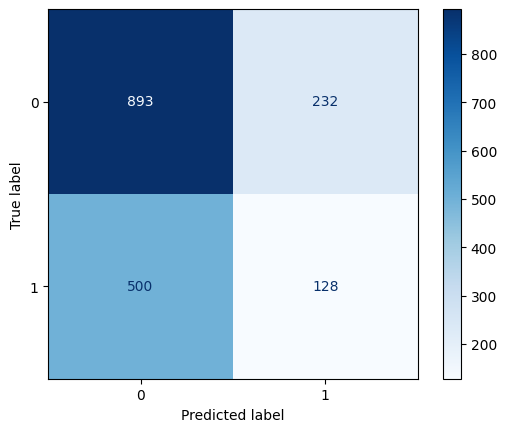

In [9]:
# Cell 8: Confusion Matrix plot

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=best_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()